In [ ]:
#Author: Siyu Jia

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import norm
import pdb

class BS():
    
    def CallPrice(S, T, K, sigma, r):
        #S = S0
        #T = time to maturity
        #K = Strike price of option
        #sigma = vol
        #r = risk-free
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*norm.cdf(dp) - K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return K*np.exp(-r*T)*norm.cdf(-dm) - S*norm.cdf(-dp)
    
    
    def CallDelta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.cdf(dp)
    
    def PutDelta(S, T, K, sigma, r):
        
        return BS.CallDelta(S, T, K, sigma, r)-1
    
    def CallGamma(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)/(S*sigma*np.sqrt(T))
    
    def PutGamma(S, T, K, sigma, r):
        
        return BS.CallGamma(S, T, K, sigma, r)

In [2]:
#return matrix of GBM simulation 10000x64, 每一行都是stock price in 63 days
def sim(mu,sigma,S0,T,sim_num):
    
    dt = 1/252
    sims = np.full((int(sim_num),int((T*252)+1)),np.nan)
    sims[:,0] = S0
    for i in range (int(T*252)):
        rand = np.random.normal(0,np.sqrt(dt),sim_num)
        sims[:,i+1] = sims[:,i]*np.exp((mu-(1/2)*(sigma**2))*dt+sigma*rand)
        
    return sims

In [3]:
#Q1

Text(0.5, 1.0, 'Time Based P&L --- Delta Hedging')

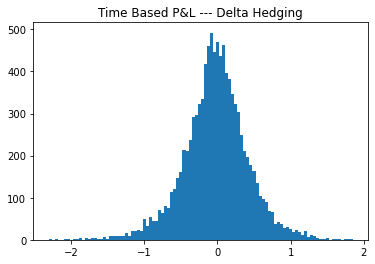

In [3]:
#delta hedging time based
np.random.seed(456)
import matplotlib.pyplot as plt
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
#time-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account1 = np.full_like(simulations,np.nan)
delta0 = BS.PutDelta(S0, T_put, K, sigma, r)
M0_put = BS.PutPrice(S0, T_put, K, sigma, r) - delta0*S0 - trans_equity*np.abs(delta0)
bank_account1[:,0] = M0_put
delta = []
delta += [delta0]
#M(r,t,M0,S_price,transaction_cost,delta0,delta)
for i in range(put_T):
    
    T = T_put - (i + 1) * dt
    if i == put_T - 1:
        delta_new = 0
    else: 
        delta_new = BS.PutDelta(simulations[:,i+1], T, K, sigma, r)
    delta += [delta_new]
    bank_account1[:,i+1] = bank_account1[:,i]*np.exp(r*dt) - \
    (delta_new - delta[-2])*simulations[:,i+1] - \
    trans_equity*(np.abs((delta_new - delta[-2])))
    
for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account1[ii,-1] = bank_account1[ii,-1] - (K - simulations[ii,-1])

plt.hist(bank_account1[:,-1],bins = 100)
plt.title('Time Based P&L --- Delta Hedging')

In [7]:
len(bank_account1[1,:])

64

In [5]:
var = np.percentile(bank_account1[:,-1],10)
print(var)

-0.5402953765395865


In [6]:
CVaR= np.mean(bank_account1[:,-1][bank_account1[:,-1] <= var])
print(CVaR)

-0.845432094096318


In [7]:
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

4.554722921689006


100%|██████████| 10000/10000 [01:03<00:00, 158.16it/s]


Text(0.5, 1.0, 'Move Based P&L --- Delta Hedging')

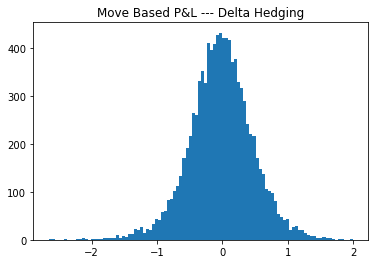

In [8]:
#delta hedging move based
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(456)
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
lower_limit = -0.99
upper_limit = -0.01
limit = 0.05
#move-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account2 = np.full_like(simulations,np.nan)
delta0 = BS.PutDelta(S0, T_put, K, sigma, r)
M0_put = BS.PutPrice(S0, T_put, K, sigma, r) - delta0*S0 - trans_equity*np.abs(delta0)
bank_account2[:,0] = M0_put
#previous_delta = delta0.copy()

for t in tqdm(range(sim_num)):
    previous_delta = delta0.copy()
    flag = 0 #first in
    for i in range(put_T):
        if i == put_T - 1:
            delta_new = 0
            bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
        else:
            
            T = T_put - (i+1) * dt
            delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r)
            upper = previous_delta + 0.05
            lower = previous_delta - 0.05
          
            if delta_new >= -0.01:
                if flag  == 0:
                    upper = 0
                    lower = delta_new - 0.05
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt)


            elif delta_new <= -0.99:
                if flag  == 0:
                    upper = delta_new + 0.05
                    lower = -1
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt)


            elif delta_new <= upper_limit and delta_new >= lower_limit:
                if delta_new >= lower and delta_new <= upper:
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt)

                else:
                    bank_account2[t,i+1] = bank_account2[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    upper = delta_new + 0.05
                    lower = delta_new - 0.05
                    previous_delta = delta_new.copy()
                    flag = 0

for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account2[ii,-1] = bank_account2[ii,-1] - (K - simulations[ii,-1])  
        

plt.hist(bank_account2[:,-1],bins = 100)
plt.title('Move Based P&L --- Delta Hedging')         

In [9]:
var = np.percentile(bank_account2[:,-1],10)
print(var)
CVaR= np.mean(bank_account2[:,-1][bank_account2[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.6029133784117722
-0.9089820955940068
4.61795596623192


In [10]:
#Q2

Text(0.5, 1.0, 'Time Based P&L --- Delta Gamma Hedging')

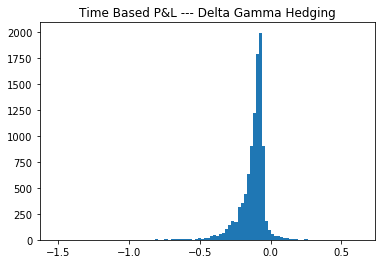

In [11]:
#delta gamma hedging time based
np.random.seed(456)
import matplotlib.pyplot as plt
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
T_call = 0.5
#time-based delta gamma hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account3 = np.full_like(simulations,np.nan)
#gamma0
num_calloption = BS.PutGamma(S0, T_put, K, sigma, r) / BS.CallGamma(S0, T_call, K, sigma, r)
#delta0
num_stock = BS.PutDelta(S0, T_put, K, sigma, r) - num_calloption*BS.CallDelta(S0, T_call, K, sigma, r)
#option price at t = 0
option_price0 = BS.CallPrice(S0, T_call, K, sigma, r)
M0 = BS.PutPrice(S0, T_put, K, sigma, r) - \
     num_stock*S0 - \
     trans_equity*np.abs(num_stock) - \
     num_calloption*option_price0 - \
     trans_option*np.abs(num_calloption)
bank_account3[:,0] = M0
delta = []
delta += [num_stock]
gamma = []
gamma += [num_calloption]
#M(r,t,M0,S_price,transaction_cost,delta0,delta)
for i in range(put_T):
    Tcall = T_call - (i + 1) * dt
    T = T_put - (i + 1) * dt
    if i == put_T - 1:
        delta_new = 0
        gamma_new = 0
        option_price = BS.CallPrice(simulations[:,i+1], Tcall, K, sigma, r)
        
    else: 
        option_price = BS.CallPrice(simulations[:,i+1], Tcall, K, sigma, r)
        gamma_new = BS.PutGamma(simulations[:,i+1], T, K, sigma, r) / BS.CallGamma(simulations[:,i+1], Tcall, K, sigma, r)
        delta_new = BS.PutDelta(simulations[:,i+1], T, K, sigma, r) - \
        gamma_new*BS.CallDelta(simulations[:,i+1], Tcall, K, sigma, r)
    delta += [delta_new]
    gamma += [gamma_new]
    bank_account3[:,i+1] = bank_account3[:,i]*np.exp(r*dt) - \
    (delta_new - delta[-2])*simulations[:,i+1] - \
    trans_equity*(np.abs(delta_new - delta[-2])) - \
    (gamma_new - gamma[-2])*option_price - \
    trans_option*(np.abs(gamma_new - gamma[-2]))
    
for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account3[ii,-1] = bank_account3[ii,-1] - (K - simulations[ii,-1])

plt.hist(bank_account3[:,-1],bins = 100)
plt.title('Time Based P&L --- Delta Gamma Hedging')

In [12]:
var = np.percentile(bank_account3[:,-1],10)
print(var)
CVaR= np.mean(bank_account3[:,-1][bank_account3[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.23103564115408717
-0.32696904694019324
4.038845719768397


100%|██████████| 10000/10000 [08:35<00:00, 19.40it/s]


Text(0.5, 1.0, 'Move Based P&L --- Delta Gamma Hedging')

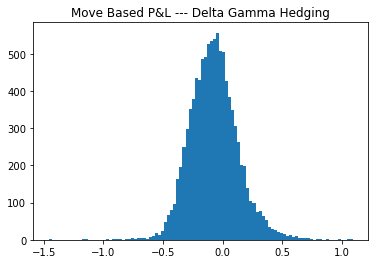

In [13]:
#这个暂时先不弄，这个是第二题的move based
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(456)
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
T_call = 0.5
lower_limit = -0.99
upper_limit = -0.01
limit = 0.05
#move-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account4 = np.full_like(simulations,np.nan)
#gamma0
num_calloption = BS.PutGamma(S0, T_put, K, sigma, r) / BS.CallGamma(S0, T_call, K, sigma, r)
#delta0
num_stock = BS.PutDelta(S0, T_put, K, sigma, r) - num_calloption*BS.CallDelta(S0, T_call, K, sigma, r)
#option price at t = 0
option_price0 = BS.CallPrice(S0, T_call, K, sigma, r)
M0 = BS.PutPrice(S0, T_put, K, sigma, r) - \
     num_stock*S0 - \
     trans_equity*np.abs(num_stock) - \
     num_calloption*option_price0 - \
     trans_option*np.abs(num_calloption)
bank_account4[:,0] = M0

#move based
for t in tqdm(range(sim_num)):
    previous_delta = num_stock.copy()
    previous_gamma = num_calloption.copy()
    #adj_delta = BS.PutDelta(S0, T_put, K, sigma, r).copy()
    delta_call0 = BS.CallDelta(S0, T_call, K, sigma, r).copy()
    previous_band = previous_delta+previous_gamma*delta_call0
    flag = 0 #first in
    for i in range(put_T):
        if i == put_T - 1:
            Tcall = T_call - (i + 1) * dt
            option_price = BS.CallPrice(simulations[t,i+1], Tcall, K, sigma, r)
            gamma_new = 0
            delta_new = 0
            bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt) - \
            (delta_new - previous_delta)*simulations[t,i+1] - \
            trans_equity*(np.abs(delta_new - previous_delta)) - \
            (gamma_new - previous_gamma)*option_price - \
            trans_option*(np.abs(gamma_new - previous_gamma))
            
        else:
            Tcall = T_call - (i + 1) * dt
            T = T_put - (i+1) * dt
            option_price = BS.CallPrice(simulations[t,i+1], Tcall, K, sigma, r)
            gamma_new = BS.PutGamma(simulations[t,i+1], T, K, sigma, r) / BS.CallGamma(simulations[t,i+1], Tcall, K, sigma, r)
            delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r) - \
            gamma_new*BS.CallDelta(simulations[t,i+1], Tcall, K, sigma, r)
            adj_delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r)
            
            previous_band = previous_delta+previous_gamma*BS.CallDelta(simulations[t,i+1], Tcall, K, sigma, r)
            upper = previous_band + 0.05
            lower = previous_band - 0.05
          
            if adj_delta_new >= -0.01:
                if flag  == 0:
                    upper = 0
                    lower = adj_delta_new - 0.05
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta)) - \
                    (gamma_new - previous_gamma)*option_price - \
                    trans_option*(np.abs(gamma_new - previous_gamma))
                    flag = 1
                    previous_delta = delta_new.copy()
                    previous_gamma = gamma_new.copy()
                elif flag == 1:
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt)


            elif adj_delta_new <= -0.99:
                if flag  == 0:
                    upper = adj_delta_new + 0.05
                    lower = -1
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta)) - \
                    (gamma_new - previous_gamma)*option_price - \
                    trans_option*(np.abs(gamma_new - previous_gamma))
                    flag = 1
                    previous_delta = delta_new.copy()
                    previous_gamma = gamma_new.copy()
                elif flag == 1:
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt)


            elif adj_delta_new <= upper_limit and adj_delta_new >= lower_limit:
                if adj_delta_new >= lower and adj_delta_new <= upper:
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt)

                else:
                    bank_account4[t,i+1] = bank_account4[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta)) - \
                    (gamma_new - previous_gamma)*option_price - \
                    trans_option*(np.abs(gamma_new - previous_gamma))
                    upper = previous_delta+previous_gamma*BS.CallDelta(simulations[t,i+1], Tcall, K, sigma, r) + 0.05
                    lower = previous_delta+previous_gamma*BS.CallDelta(simulations[t,i+1], Tcall, K, sigma, r) - 0.05
                    previous_delta = delta_new.copy()
                    previous_gamma = gamma_new.copy()
                    flag = 0

for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account4[ii,-1] = bank_account4[ii,-1] - (K - simulations[ii,-1])   
        

plt.hist(bank_account4[:,-1],bins = 100)
plt.title('Move Based P&L --- Delta Gamma Hedging')         

In [14]:
var = np.percentile(bank_account3[:,-1],10)
print(var)
CVaR= np.mean(bank_account4[:,-1][bank_account4[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.23103564115408717
-0.3306274330994999
4.042485859650613


In [15]:
#Q3 Change bands

100%|██████████| 10000/10000 [01:03<00:00, 158.41it/s]


Text(0.5, 1.0, 'Move Based P&L --- Delta Hedging')

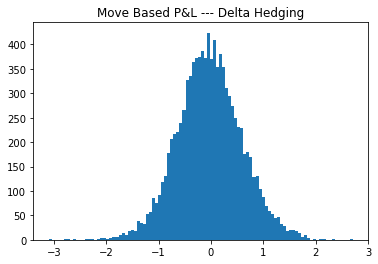

In [16]:
#bands = 0.2
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(456)
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
lower_limit = -0.99
upper_limit = -0.01
limit = 0.1
#move-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account5 = np.full_like(simulations,np.nan)
delta0 = BS.PutDelta(S0, T_put, K, sigma, r)
M0_put = BS.PutPrice(S0, T_put, K, sigma, r) - delta0*S0 - trans_equity*np.abs(delta0)
bank_account5[:,0] = M0_put
#previous_delta = delta0.copy()

for t in tqdm(range(sim_num)):
    previous_delta = delta0.copy()
    flag = 0 #first in
    for i in range(put_T):
        if i == put_T - 1:
            delta_new = 0
            bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
        else:
            
            T = T_put - (i+1) * dt
            delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r)
            upper = previous_delta + 0.1
            lower = previous_delta - 0.1
          
            if delta_new >= -0.01:
                if flag  == 0:
                    upper = 0
                    lower = delta_new - 0.1
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt)


            elif delta_new <= -0.99:
                if flag  == 0:
                    upper = delta_new + 0.1
                    lower = -1
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt)


            elif delta_new <= upper_limit and delta_new >= lower_limit:
                if delta_new >= lower and delta_new <= upper:
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt)

                else:
                    bank_account5[t,i+1] = bank_account5[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    upper = delta_new + 0.1
                    lower = delta_new - 0.1
                    previous_delta = delta_new.copy()
                    flag = 0

for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account5[ii,-1] = bank_account5[ii,-1] - (K - simulations[ii,-1])  
        

plt.hist(bank_account5[:,-1],bins = 100)
plt.title('Move Based P&L --- Delta Hedging')         

In [17]:
var = np.percentile(bank_account5[:,-1],10)
print(var)
CVaR= np.mean(bank_account5[:,-1][bank_account5[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.782909306037262
-1.0938871213170074
4.801938774291749


100%|██████████| 10000/10000 [01:03<00:00, 156.51it/s]


Text(0.5, 1.0, 'Move Based P&L --- Delta Hedging')

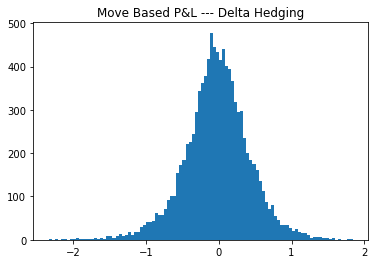

In [18]:
#bands = 0.05
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(456)
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
lower_limit = -0.99
upper_limit = -0.01
limit = 0.025
#move-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account6 = np.full_like(simulations,np.nan)
delta0 = BS.PutDelta(S0, T_put, K, sigma, r)
M0_put = BS.PutPrice(S0, T_put, K, sigma, r) - delta0*S0 - trans_equity*np.abs(delta0)
bank_account6[:,0] = M0_put
#previous_delta = delta0.copy()

for t in tqdm(range(sim_num)):
    previous_delta = delta0.copy()
    flag = 0 #first in
    for i in range(put_T):
        if i == put_T - 1:
            delta_new = 0
            bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
        else:
            
            T = T_put - (i+1) * dt
            delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r)
            upper = previous_delta + 0.025
            lower = previous_delta - 0.025
          
            if delta_new >= -0.01:
                if flag  == 0:
                    upper = 0
                    lower = delta_new - 0.025
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt)


            elif delta_new <= -0.99:
                if flag  == 0:
                    upper = delta_new + 0.025
                    lower = -1
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt)


            elif delta_new <= upper_limit and delta_new >= lower_limit:
                if delta_new >= lower and delta_new <= upper:
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt)

                else:
                    bank_account6[t,i+1] = bank_account6[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    upper = delta_new + 0.025
                    lower = delta_new - 0.025
                    previous_delta = delta_new.copy()
                    flag = 0

for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account6[ii,-1] = bank_account6[ii,-1] - (K - simulations[ii,-1])  
        

plt.hist(bank_account6[:,-1],bins = 100)
plt.title('Move Based P&L --- Delta Hedging')         

In [19]:
var = np.percentile(bank_account6[:,-1],10)
print(var)
CVaR= np.mean(bank_account6[:,-1][bank_account6[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.5520259165810829
-0.8529217708657036
4.562175243539664


100%|██████████| 10000/10000 [01:03<00:00, 157.65it/s]


Text(0.5, 1.0, 'Move Based P&L --- Delta Hedging')

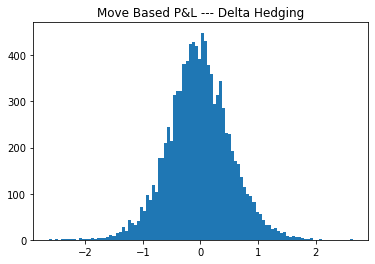

In [20]:
#bands = 0.15
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(456)
S0 = 100
sigma = 0.2
mu = 0.1
r = 0.02
K = 100
put_T = int(252*1/4) #NdT_put
call_T = int(252*1/2) #NdT_call
trans_equity = 0.005
trans_option = 0.01
sim_num = 10000
dt = 1/252
T_put = 0.25
lower_limit = -0.99
upper_limit = -0.01
limit = 0.075
#move-based delta hedging
simulations = sim(mu,sigma,S0,T_put,sim_num)
bank_account7 = np.full_like(simulations,np.nan)
delta0 = BS.PutDelta(S0, T_put, K, sigma, r)
M0_put = BS.PutPrice(S0, T_put, K, sigma, r) - delta0*S0 - trans_equity*np.abs(delta0)
bank_account7[:,0] = M0_put
#previous_delta = delta0.copy()

for t in tqdm(range(sim_num)):
    previous_delta = delta0.copy()
    flag = 0 #first in
    for i in range(put_T):
        if i == put_T - 1:
            delta_new = 0
            bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
        else:
            
            T = T_put - (i+1) * dt
            delta_new = BS.PutDelta(simulations[t,i+1], T, K, sigma, r)
            upper = previous_delta + 0.075
            lower = previous_delta - 0.075
          
            if delta_new >= -0.01:
                if flag  == 0:
                    upper = 0
                    lower = delta_new - 0.075
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt)


            elif delta_new <= -0.99:
                if flag  == 0:
                    upper = delta_new + 0.075
                    lower = -1
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    flag = 1
                    previous_delta = delta_new.copy()
                elif flag == 1:
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt)


            elif delta_new <= upper_limit and delta_new >= lower_limit:
                if delta_new >= lower and delta_new <= upper:
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt)

                else:
                    bank_account7[t,i+1] = bank_account7[t,i]*np.exp(r*dt) - \
                    (delta_new - previous_delta)*simulations[t,i+1] - \
                    trans_equity*(np.abs(delta_new - previous_delta))
                    upper = delta_new + 0.075
                    lower = delta_new - 0.075
                    previous_delta = delta_new.copy()
                    flag = 0

for ii in range(sim_num):
    if K > simulations[ii,-1]:
        bank_account7[ii,-1] = bank_account7[ii,-1] - (K - simulations[ii,-1])  
        

plt.hist(bank_account7[:,-1],bins = 100)
plt.title('Move Based P&L --- Delta Hedging')         

In [21]:
var = np.percentile(bank_account7[:,-1],10)
print(var)
CVaR= np.mean(bank_account7[:,-1][bank_account7[:,-1] <= var])
print(CVaR)
M = - CVaR - 0.02
M_discounted = M * np.exp(-r*T_put)
adjusted_price = BS.PutPrice(S0, T_put, K, sigma, r) + M_discounted
print(adjusted_price)

-0.6845088062534956
-0.9877629708636069
4.6963439202468935


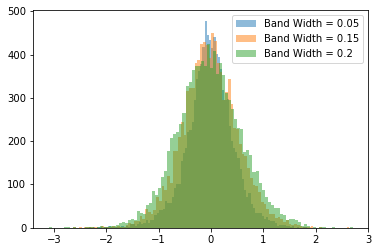

In [22]:
#Band width smaller, peak higher; band width larger, more flat
plt.hist(bank_account6[:,-1],bins=100, alpha = 0.5, label = "Band Width = 0.05")
plt.hist(bank_account7[:,-1],bins=100, alpha = 0.5, label = "Band Width = 0.15")
plt.hist(bank_account5[:,-1],bins=100, alpha = 0.5, label = "Band Width = 0.2")
plt.legend(loc="upper right")
plt.show()